# Classifying seismic receiver functions using logistic regression

# 1. Introduction to USArray data
The seismic data we are going to use for this lab exercise was recorded by USArray Transportable Array (TA). The TA has traversed the continental United States and collected voluminous amounts of broadband seismic data that contain extremely rich information for mapping the structures of the Earth’s interior underneath North America. It is currently being deployed in Alaska.

Here is a picutre summarizing the locations of current USArray TA seismic receivers.
<img src="https://drive.google.com/uc?id=1rEkXp-Y6nriEcqRCmP6_QltpY4eCSkaN">

The data we are going to classify is actually the P-wave receiver functions that were computed based on raw seismic data. P-wave receiver functions are widely used in crustal studies, because they provide important information about the crustal thickness. The seismological data used in our study are from earthquakes with a distance range of $30^\circ$ to $90^\circ$ and a magnitude of Mb 5 and above recorded at 201 stations in Alaska from the TA and Alaska Regional Network. 12,597 receiver function traces were obtained, and manually labeled ‘good’ or ‘bad’.

To learn more about USArray data, please refer to the following resources: <br>
1\. http://www.usarray.org/researchers/dataas  <br>
2\. http://ds.iris.edu/ds/nodes/dmc/earthscope/usarray/ <br>
3\. http://www.usarray.org/Alaska <br>
<br>
For more information on receiver functions, please refer to the following materials: <br>
1\. https://ds.iris.edu/media/workshop/2013/01/advanced-studies-institute-on-seismological-research/files/lecture_introrecf.pdf <br>
2\. http://www.diss.fu-berlin.de/diss/servlets/MCRFileNodeServlet/FUDISS_derivate_000000001205/3_Chapter3.pdf?hosts= <br>
<br>


# 2. Import data

Download the Traces dataset at https://drive.google.com/file/d/1vSBcmbga-o8Eti1e5S08LwPD0hCmjL2c/view?usp=share_link

Import the data from Traces_qc.mat.

In [2]:
import numpy as np
import h5py  # The h5py package is a Pythonic interface to the HDF5 binary data format. https://www.h5py.org/
with h5py.File("./Traces_qc.mat") as f:
    # in order for the above to work, makes sure that your Google Drive has such a path: My Drive/UH_MachineLearning_2021/Lab3_LogisticRegression/.
    ampdata = [f[element[0]][:] for element in f["Data"]["amps"]]  # Trace amplitudes
    flag = [f[element[0]][:] for element in f["Data"]["Flags"]]  # labels: 1 is good, 0 is bad
    ntr = [f[element[0]][:] for element in f["Data"]["ntr"]]  # number of traces at a station
    time = [f[element[0]][:] for element in f["Data"]["time"]]  # time sequent for each trace
    staname = [f[element[0]][:] for element in f["Data"]["staname"]] # station name

In [3]:
ampall = np.zeros((1,651))
flagall = np.zeros(1)
for i in np.arange(201):  # there are 201 stations
    ampall = np.vstack((ampall, ampdata[i]))
    flagall = np.vstack((flagall, flag[i]))
amp_data = np.delete(ampall, 0, 0)
flag_data = np.delete(flagall, 0, 0)

The **amp_data** stores the seismic amplitudes from all seismic stations. The **flag_data** contains the labels for each seismic traces. These labels are encoded as 1s and 0s, with 0 representing bad seismic traces, and 1 corresponding good seismic traces. Recall that, logistic regression is a supervised machine learning, and therefore, it requires labels. Also recall that, logistic regression is a binary classification algorithm, and the labels are most often expressed numerically as 0s and 1s. 

In [4]:
print('Ther are', amp_data.shape[0], 'seismic traces')
print('And',flag_data.shape[0],'labels')
print('From',len(staname),'seismic stations')  # 'staname' is a list. Use len() for its size.

Ther are 12597 seismic traces
And 12597 labels
From 201 seismic stations


# 3. Visualize data


Plot up a few 'good' seismic traces which are all labeled as 1s.

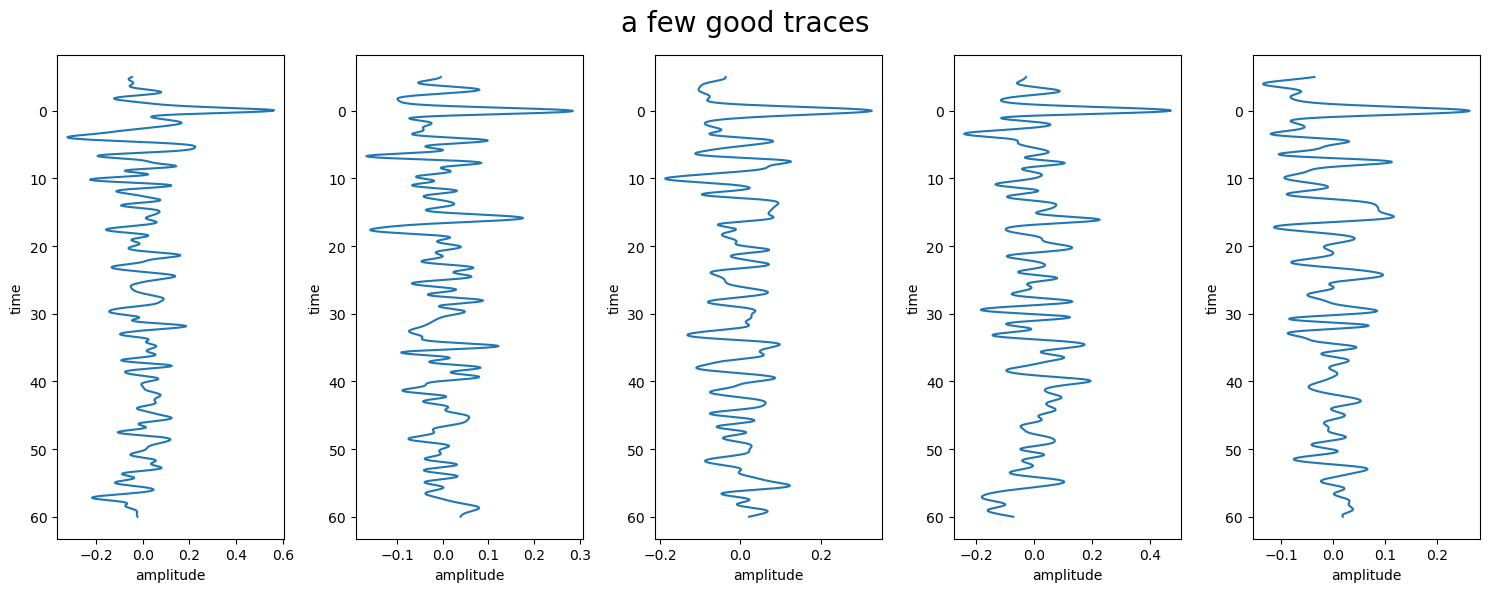

In [5]:
goodtraceindex = np.nonzero(flag_data)[0].reshape(-1,1)
# ploting a few good traces (before scaling is applied)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle('a few good traces', fontsize=20)

axs = axs.ravel()
ic = 0
for icount in goodtraceindex[:5,0]:       

    axs[ic].plot(amp_data[icount,:], time[0])
    axs[ic].invert_yaxis()
    axs[ic].set_xlabel('amplitude')
    axs[ic].set_ylabel('time')
        
    ic = ic + 1
        
plt.tight_layout()      
plt.show()       

There are a few obvious features that are common to all 'good' traces. First, there is a distinct peak at time 0. Second, there is a second peak around 5 seconds. (Providing information about the crustal thickness). Thirdly, the amplitude for the peak at time 0 should be clearly higher than that for the second peak.
<br>



Plot some of the 'bad' seismic traces.

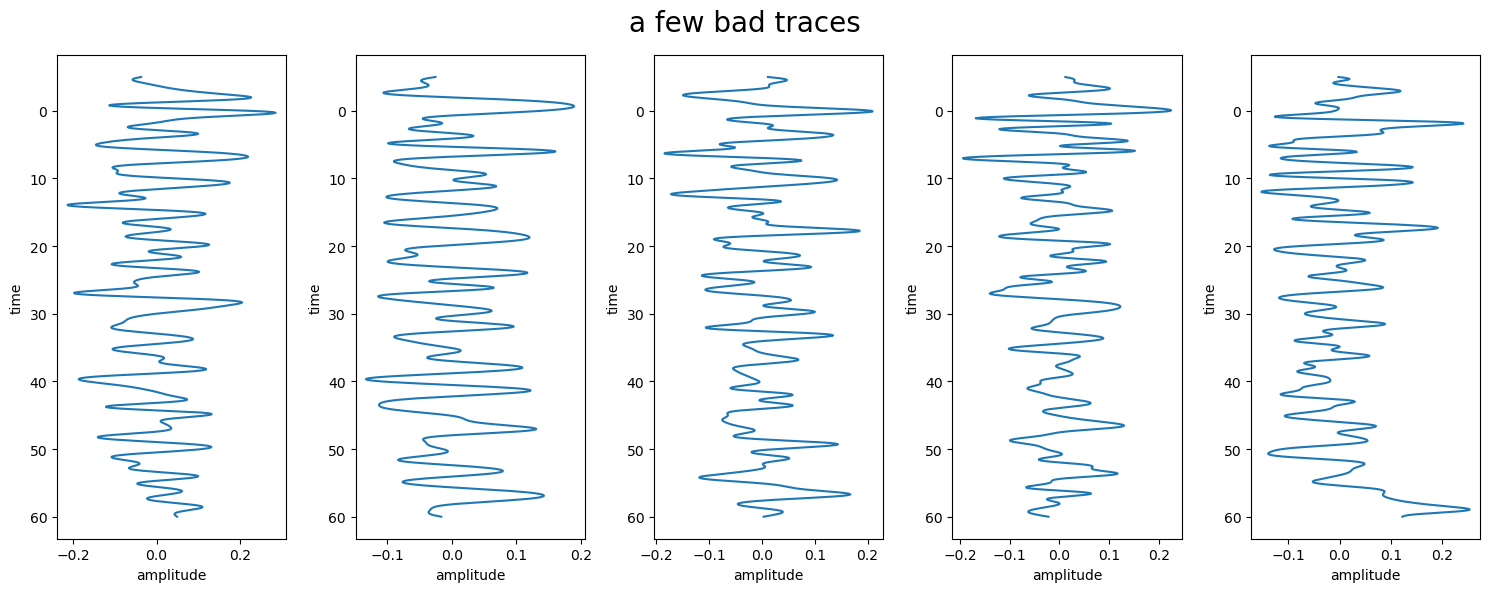

In [6]:
badtraceindex = np.where(flag_data==0)[0].reshape(-1,1)
# plot a few good traces (before scaling is applied)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle('a few bad traces', fontsize=20)

axs = axs.ravel()
ic = 0
for icount in badtraceindex[5:10,0]:       
              
    axs[ic].plot(amp_data[icount,:], time[0])
    axs[ic].invert_yaxis()
    axs[ic].set_xlabel('amplitude')
    axs[ic].set_ylabel('time')
        
    ic = ic + 1
         
plt.tight_layout()      
plt.show()     

# 3. Preprocessing (i.e., preparing data for subsequent machine learning)

One common preprocessing step is to normalize data so that they have a mean of 0 and a standard deviation of 1. The reasons for doing this are twofold. First, for practical machine learning problems, different features have different scales. For example, when it comes to predicting life satisfaction, the GPD per capita might be on the order of ~1000s, whereas the education system might be ranked on a scale of 0 to 1, with 1 representing the best education. It turns out, features with vastly different scales make the optimization biased toward the ones that have large values (e.g., GPD per capita instead of education system). Secondly, for minimization, the shape of the cost function associated with features of different scales becomes elongated, making the gradient descent type of algorithms less efficient. <br>
<br>


Scaling (or, normalizing) is typically done using Scikit-learn. 

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(amp_data)
scaled_ampdata = scaler.transform(amp_data)

In [10]:
# Find out how many traces are labled as 'bad'
scaled_ampdata[np.where(flag_data == 0)[0],:].shape[0]

9632

In [11]:
# Find out how many traces are labeled as 'good'
scaled_ampdata[np.nonzero(flag_data)[0],:].shape[0]

2965

In [12]:
# Total number of seismic traces
scaled_ampdata.shape[0]

12597

Next, we need to randomly permute these data for the machine learning. The reason is to avoid the situation where your training data are ordered in some specific way. For example, it might happen that all the good seismic traces are together, followed by all the bad traces. If we are not careful, our training data set might be all the good seismic traces, and our validation or test data set might be all the bad ones. This is very dangerous because the machine lerning algorithm will not have any chance of learning from the bad seismic traces at the training stage, and you can expect that no matter how you train a machine learning model, it will not predict well on the validation/test data. Randomly permuting the data will ensure that the training set contains data from every category (good and bad), and validation/test set also contains data from all categories. 

In [13]:
np.random.seed(42)
whole_data = np.append(scaled_ampdata,flag_data,1) # put all the seismic traces 
# and their lables into one matrix which contain the whole data set for subsequent machine learing.
training_data_permute = whole_data[np.random.permutation(whole_data.shape[0]),:] 

# 4. Split the data into training and validation sets

This method is done to figure out the preformance of the algorithms. The training dataset is a sample of the data which is used to fit the model and the validation dataset is a sample of unbiased data used to evaluate the fit of the model. If necessary, the validation dataset is also used to fine tune the model later on. This article provides a good reference to this method: [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/)

We are going to use the first 2000 seismic traces and their corresponding labels as our training data set.

In [14]:
X_train = training_data_permute[0:2000,:-1]
y_train = training_data_permute[0:2000,-1]

Similarly, we are going to put aside the seismic traces with indices from 10000 to the very end as our validation (or test) data set.

In [15]:
X_validation = training_data_permute[10000:,:-1]
y_validation = training_data_permute[10000:,-1]

# 5. Implementing logistic regression using Scikit-learn

In [16]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg = LogisticRegression(random_state=42,solver='newton-cg')

Train a logistic regession model using our training data, i.e., X_train and y_train.


In [20]:
log_reg.fit(X_train,y_train)

LogisticRegression(random_state=42, solver='newton-cg')

# 6. Evaluation of the learned logistic regression model

Output the accuracy (or score) of the predictions on the **training** data set. 



In [21]:
trainAcc = log_reg.score(X_train,y_train)
print('Training accuracy is %s'%trainAcc)

Training accuracy is 0.83


Output the accuracy (or score) of the predictions on the **validation** data set. 



In [22]:
validationAcc = log_reg.score(X_validation,y_validation)
print('Validation accuracy is %.02f'%validationAcc)

Validation accuracy is 0.80


Output the error of the predictions on both the **training** and **validation** data sets. 


Accuracy of the logistical regression is defined as:
<br>
   $$ accuracy = 1 - \frac{1}{m}\sum_{i=1}^M (y_{pred}^{i} - y^{(i)})^2 $$
where $y_{pred}^{i}$ is the predicted label for the $i^{th}$ instance (or example). Both $y_{pred}^i$ and $y^i$ can only take on either 0 or 1.



In [23]:
trainErr = 1 - trainAcc
print('Training error is %0.02f'%trainErr)
validationErr = 1 - validationAcc
print('Validation error is %0.02f'%validationErr)

Training error is 0.17
Validation error is 0.20


# 7. Constructing error curves

So far, we have only used 2,000 seismic traces as our training data set. But remember that we can use up to 10,000 traces as our training data set (the remaining 2,597 traces were reserved for validation). For this task, create a training data set with 4000 seismic traces (do not touch the validation data set that we set previously). And 
compute the errors of the predictions on both training and validation data sets. Similary, create a training data set with 6000, 8000 and 10000 seismic traces, and compute their respective errors on both training and validation data sets. 


In [24]:
# Train a set for 4000 seismic traces 
"""
The validation dataset remains the same so a new one is not 
calculated.
"""
X_train1 = training_data_permute[0:4000,:-1]
y_train1 = training_data_permute[0:4000,-1]
log_reg.fit(X_train1,y_train1)
trainErr1 = 1 - log_reg.score(X_train1,y_train1)
validationErr1 = 1 - log_reg.score(X_validation,y_validation)

# 6000 seismic traces
X_train2 = training_data_permute[0:6000,:-1]
y_train2 = training_data_permute[0:6000,-1]
log_reg.fit(X_train2,y_train2)
trainErr2 = 1 - log_reg.score(X_train2,y_train2)
validationErr2 = 1 - log_reg.score(X_validation,y_validation)

# 8000 seismic traces
X_train3 = training_data_permute[0:8000,:-1]
y_train3 = training_data_permute[0:8000,-1]
log_reg.fit(X_train3,y_train3)
trainErr3 = 1 - log_reg.score(X_train3,y_train3)
validationErr3 = 1 - log_reg.score(X_validation,y_validation)

# 10000 seismic traces
X_train4 = training_data_permute[0:10000,:-1]
y_train4 = training_data_permute[0:10000,-1]
log_reg.fit(X_train4,y_train4)
trainErr4 = 1 - log_reg.score(X_train4,y_train4)
validationErr4 = 1 - log_reg.score(X_validation,y_validation)

Store the errors of the predictions on **training** data using 2000, 4000, 6000, 8000, and 10000 seismic traces in a Numpy array **train_errors**. Similarly, store the errors of the predictions on **validation** data using 2000, 4000, 6000, 8000, and 10000 seismic traces in a Numpy array **validation_errors**. <br>
<br>


In [25]:
# Create training error vector
train_errors = np.array([trainErr, trainErr1, trainErr2, trainErr3, trainErr4])
validation_errors = np.array([validationErr,validationErr1,validationErr2,validationErr3,validationErr4])


Now let us plot up the error curves.

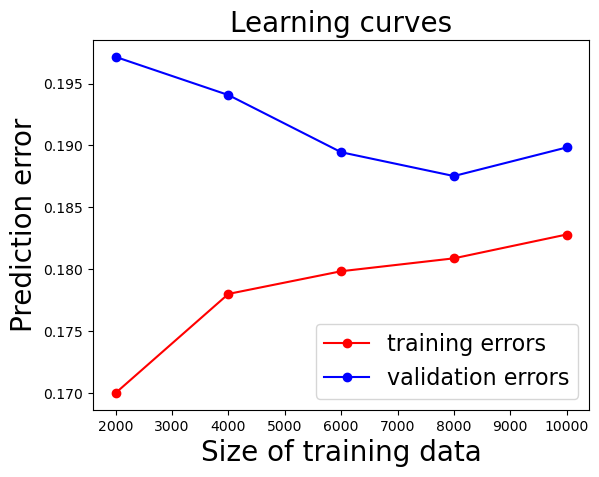

In [26]:
import matplotlib.pyplot as plt
trainingsize =  np.array([2000,4000,6000,8000,10000])
plt.plot(trainingsize,train_errors,'-ro',label="training errors")
plt.plot(trainingsize,validation_errors,'-bo',label="validation errors")
plt.title('Learning curves',fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.xlabel("Size of training data", fontsize=20)
plt.ylabel("Prediction error", fontsize=20, rotation=90)
plt.show()

## Summarization the change of training and validation errors as the size of the training data increases. 

As the training dataset gets larger, the training errors increase ~1.5%, while the validation errors decrease around ~0.5%. The gap between the validation and training errors closes around the size of 8000 (training dataset), where the validation error begins to increase again, so 8000 seems to be the minimum.

Since 8000 is the minimum for the validation error, and it begins to get larger afterwards and the training error steadily increses, there coul be underfitting taking place after the minimum. This is because if $J_{train}$ is large and $J_v$ is large, than underfitting is occuring. Howerver, beforr a $J_{train}$ size of 8000 the validation error is dropping. I would say a $J_{train}$ size of 8000 yeilds the best results.


# Acknowledgments
I would like to thank Ying Zhang for manually labeling all the seismic traces, and Prof. Aibing Li for making this data set available to the students in this class. Ms. Zhang also kindly explained the fundamentals of seismic P-wave receiver functions to a non-seismic person <br>

<img src = "https://drive.google.com/uc?id=19M3C-0oUcaWY_o1MziDQf3g5ARVOEZmK">

